## Modelo LDA para identificar temas en contratos Obra SECOP

### Cargar librerías

In [2]:
# Librerias

import csv
import pandas as pd
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.utils import deaccent


from nltk.corpus import stopwords
lista_stopwords = stopwords.words("spanish")

import spacy

## es_
nlp = spacy.load("es_core_news_md")

# Importadas por JP
import time
from pprint import pprint
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

### Funciones personalizadas

In [3]:
# Funciones

## Función para abrir e iterar el archivo de los contratos linea por linea

def iter_csv_file(filename, column_name):
    """
    Esta función toma un archivo CSV y el nombre de una columna y devuelve un iterador que
    produce los valores de esa columna para cada fila en el archivo.
    
    Argumentos:
        filename (str): El nombre del archivo CSV a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.
        
    Yields:
        El valor de la columna especificada para cada fila en el archivo.
        
    Ejemplo de uso:
    
    >>> for value in iter_csv_file('datos.csv', 'edad'):
            print(value)
            
        27
        35
        42
        18
        ...
    """
    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            yield row[column_name]

## Función para iterar la fila de una columna de un dataframe linea por linea, se utiliza para generar el corpus

def iter_dataframe(df, column_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce los tokens lematizados para cada fila en la columna especificada.
    
    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en la que queremos iterar.
        
    Yields:
        Una lista de los tokens lematizados para cada fila en la columna especificada.
    """
    for line in df[column_name]:
        # Tokeniza la línea utilizando simple_preprocess y se eliminan las palabras menores a 3 letras y los acentos
        tokens = simple_preprocess(line, deacc=True, min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        yield [token.lemma_ for token in doc]


## Función para iterar una columna y devolver una lista de lemas se utiliza para generar el diccionario
           


def iter_column(df, col_name):
    """
    Esta función toma un DataFrame de pandas y el nombre de una columna y devuelve un iterador que
    produce una lista de lemas para cada línea en la columna especificada.
    
    Argumentos:
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        col_name (str): El nombre de la columna en la que queremos iterar.
        
    Yields:
        Una lista de lemas para cada línea en la columna especificada.
        
    Ejemplo de uso:
    
    >>> for lemmas in iter_column(df, 'texto'):
            print(lemmas)
            
        ['comprar', 'manzana', 'pera', 'naranja']
        ['ir', 'cine', 'amigo']
        ['cocinar', 'comida', 'saludable', 'cena']
        ...
    """
    # Itera sobre cada línea en la columna especificada
    for line in df[col_name]:
        # Se eliminan los acentos de las palabras en la línea utilizando unidecode
        # Tokeniza la línea utilizando simple_preprocess
        tokens = simple_preprocess(line, deacc=True,min_len=3)
        # Se remueven las stopwords y las palabras que aparecen solo una vez antes de aplicar la lematización
        doc = [token for token in nlp(' '.join(tokens).lower()) if token.text not in lista_stopwords]
        # Itera sobre cada token en el objeto Doc y devuelve su forma lematizada utilizando el atributo lemma_
        lemmas = [token.lemma_ for token in doc]
        lemmas = [deaccent(lemma) for lemma in lemmas]
        # Genera una lista de lemas para cada línea en la columna de entrada utilizando la sentencia yield
        yield lemmas

  
## Función para crear el corpus a partir de todos los datos

class MyCorpus():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """
                
    # Constructor de la clase MyCorpus
    def __init__(self, dictionary):
        """
        Constructor de la clase MyCorpus.
        
        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        """
        self.dictionary = dictionary

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el archivo CSV.
        
        Yields:
        Una bolsa de palabras para cada línea en el archivo CSV.
        """
        # Itera sobre cada línea en el archivo CSV utilizando el método iter_csv_file
        for line in iter_csv_file('datos/df_secop_obra.csv', 'Detalle_Objeto_Contratar'):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(line.split())


# Función para crear el corpus a partir de la muestra
class MyCorpus_sample():
    """
    Esta clase es una implementación de la interfaz de corpus de Gensim, que define cómo se accede a los documentos en un corpus de texto.
    """
                
    # Constructor de la clase MyCorpus
    def __init__(self, dictionary, df, column_name):
        """
        Constructor de la clase MyCorpus.
        
        Argumentos:
        dictionary (gensim.corpora.Dictionary): Objeto de diccionario de Gensim que se utilizará para crear bolsas de palabras.
        df (pandas.DataFrame): El DataFrame de pandas a leer.
        column_name (str): El nombre de la columna en el que queremos iterar.
        """
        self.dictionary = dictionary
        self.df = df
        self.column_name = column_name

    # Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe
    def __iter__(self):
        """
        Método que devuelve un generador que produce bolsas de palabras para cada línea en el dataframe.
        
        Yields:
        Una bolsa de palabras para cada línea en el dataframe.
        """
        # Itera sobre cada línea en el dataframe utilizando el método iter_dataframe
        for line in iter_dataframe(self.df, self.column_name):
            # Convierte la lista de lemas en una bolsa de palabras utilizando el método doc2bow de self.dictionary
            yield self.dictionary.doc2bow(' '.join(line).split())


### Carga de datos - Objeto de contratos

In [4]:
# Carga de datos

## Carga de datos en en un dataframe
datos = pd.read_csv('SECOP/datos/df_secop_obra.csv' ,encoding='utf-8')

## Pasar la columna Detalle_Objeto_Contratar de object a string porque sino da un error
datos['Detalle_Objeto_Contratar']=datos['Detalle_Objeto_Contratar'].astype(str)


## Crear la muestra
#datos_sample= datos.sample(n=1800, random_state=25) #42
#datos_sample= datos[datos['Objeto_Contratar'] == 'Servicios de Salud'].sample(n=1800, random_state=7) # Revisión JP
datos_sample= datos[datos['Objeto_Contratar'] != 'Servicios de Edificación, Construcción de Instalaciones y Mantenimiento'].sample(n=1800, random_state=25) # Revisión JP

In [24]:
#datos.groupby(['Objeto_Contratar']).count()['UID']

### Stopwords asociadas a departamentos y municipios

In [5]:
# Lectura de la información de archivo departamentos

df_dpto = pd.read_csv('SECOP/datos/Regiones_Departamentos.csv', sep=';')
df_dpto = list(iter_column(df_dpto, 'Dpto_SECOP'))
lista_dpto = []
for i in df_dpto:
    lista_dpto = lista_dpto + i
lista_dpto = list(set(lista_dpto))
    
# Lectura de la información de archivo municipios

df_municipio = pd.read_csv('SECOP/datos/Departamentos_y_municipios_de_Colombia.csv', sep=',')
df_municipio = list(iter_column(df_municipio, 'MUNICIPIO'))
lista_municipio = []
for i in df_municipio:
    lista_municipio = lista_municipio + i
lista_municipio = list(set(lista_municipio))

### Crear diccionaro - Retirar Stopword

In [6]:
## Crear el diccionario con la muestra

dictionary = corpora.Dictionary(iter_column(datos_sample, 'Detalle_Objeto_Contratar'))
#dictionary.filter_extremes(no_above=0.7) # Agregado por JP

once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]

departamento_list =  ['amazonas', 'antioquia', 'arauca', 'atlantico', 'bolivar', 'boyaca', 'caldas', 'caqueta', 'casanare', 'cauca', 'cesar', 'choco', 'cordoba', 'cundinamarca', 'guainia', 'guaviare', 'huila', 'la_guajira', 'magdalena', 'meta', 'narino', 'norte_de_santander', 'putumayo','quindio', 'risaralda', 'san_andres_y_providencia', 'santander', 'sucre', 'tolima', 'valle_del_cauca', 'vaupes', 'vichada']

stoplist=['municipio', 'municipal', 'departamento', 'san', 'jose'] ##Incluir otras palabras
stoplist= stoplist + ['santa', 'corregimiento', 'norte', 'esfuerzo', 'aunar', 'locativa', 'sur', 'oriente', 'occidente',
                      'segun', 'jurisdiccion', 'barrio', 'etapa', 'casco', 'contrato', 'contratar'] # Agregadas por JP

stoplist= stoplist + lista_dpto + lista_municipio


#Generar una sola lista de palabras a filtrar
stoplist = stoplist+departamento_list

#Extraer los ids de las palabras de la listas de stoplist que coinciden con las palabras del diccionario
stop_ids = [
    dictionary.token2id[stopword]
    for stopword in stoplist
    if stopword in dictionary.token2id
]

#Funcion de filtrado

dictionary.filter_tokens( once_ids+stop_ids)

print(dictionary)

Dictionary<1586 unique tokens: ['mantenimiento', 'mejoramiento', 'rita', 'venado', 'via']...>


### Crear corpus

In [7]:
## Crear corpus con la muestra
corpus_sample= MyCorpus_sample(dictionary, datos_sample,'Detalle_Objeto_Contratar' )

### Modelo LDA

In [40]:
# Medir tiempo de inicio
start = time.time()

# Modelo Simple
Estimacion=LdaModel(corpus_sample, num_topics=2, id2word=dictionary, passes=10, eval_every = None)

top_topics = Estimacion.top_topics(corpus_sample)
num_topics=5

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

Tiempo de ejecución: 84.52238202095032
[([(0.024079354, 'construccion'),
   (0.018886724, 'servicio'),
   (0.016528104, 'calle'),
   (0.015513924, 'obra'),
   (0.015180644, 'mantenimiento'),
   (0.014055163, 'sistema'),
   (0.0119357975, 'red'),
   (0.011775724, 'instalacion'),
   (0.011659865, 'carrera'),
   (0.011556923, 'centro'),
   (0.011395544, 'alcantarillado'),
   (0.011012984, 'urbano'),
   (0.010727791, 'acueducto'),
   (0.008814061, 'realizar'),
   (0.007926788, 'suministro'),
   (0.0077477247, 'prestacion'),
   (0.007350432, 'apoyo'),
   (0.0073151686, 'proyecto'),
   (0.0066409325, 'gestion'),
   (0.0058985194, 'publico')],
  -4.633241477392058),
 ([(0.042396504, 'via'),
   (0.03989278, 'construccion'),
   (0.03449201, 'mantenimiento'),
   (0.032429423, 'mejoramiento'),
   (0.030674944, 'vereda'),
   (0.022903612, 'adecuacion'),
   (0.022273645, 'sector'),
   (0.018038245, 'rural'),
   (0.016673837, 'obra'),
   (0.015775308, 'educativo'),
   (0.0104295965, 'veredar'),
   (

### Ver resultados modelo LDA

In [43]:
# Visualizamos los resultados

pyLDAvis.enable_notebook()
LDA_visualization = gensimvis.prepare(Estimacion, list(corpus_sample), dictionary)

pyLDAvis.save_html(LDA_visualization, 'lda_2_temas_1800_XXX.HTML')
#LDA_visualization


C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Busqueda de tópicos


In [39]:
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [40]:
def find_optimal_number_of_topics(data, dictionary, start=2, end=20, step=1, coherence_measure='c_v', coherence_topn=10, workers=None):
    """
    Encuentra el número óptimo de tópicos en un modelo LDA.

    Parámetros:
    - data: un objeto gensim corpus que contiene los documentos preprocesados.
    - dictionary: un objeto gensim Dictionary que contiene el vocabulario de todas las palabras en el corpus.
    - start: el número de tópicos mínimo a evaluar.
    - end: el número de tópicos máximo a evaluar.
    - step: el intervalo de valores entre cada número de tópicos a evaluar.
    - coherence_measure: un string con el nombre de la medida de coherencia a utilizar (por defecto 'c_v').
    - coherence_topn: un número entero que indica la cantidad de palabras más relevantes a considerar para la medida de coherencia.
    - workers: el número de núcleos a utilizar para el entrenamiento del modelo LDA (por defecto None, que utiliza todos los núcleos disponibles).

    Retorna:
    - Un gráfico de línea que muestra la medida de coherencia del modelo para cada valor de num_topics evaluado.
    """

    coherence_scores = []
    models_list = []

    for num_topics in range(start, end+1, step):
        lda_model = LdaMulticore(corpus=data,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42,
                                 workers=workers)

        coherence_model_lda = CoherenceModel(model=lda_model,
                                             texts=data,
                                             dictionary=dictionary,
                                             coherence=coherence_measure,
                                             topn=coherence_topn)

        coherence_lda = coherence_model_lda.get_coherence()
        coherence_scores.append(coherence_lda)
        models_list.append(lda_model)

    # Plot coherence scores
    x = range(start, end+1, step)
    plt.plot(x, coherence_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    # Find the optimal number of topics
    optimal_num_topics = x[coherence_scores.index(max(coherence_scores))]

    # Print the optimal number of topics
    print("Optimal number of topics: ", optimal_num_topics)

    # Return the models list and coherence scores
    return models_list, coherence_scores

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


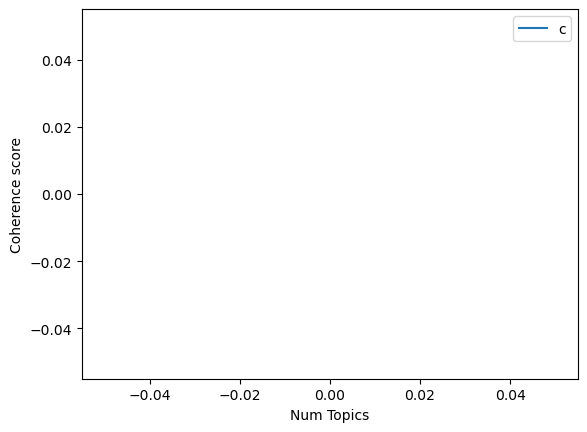

Optimal number of topics:  2


In [39]:
models_list, coherence_scores = find_optimal_number_of_topics(data=corpus_sample,
                                                              dictionary=dictionary,
                                                              start=2,
                                                              end=20,
                                                              step=1,
                                                              coherence_measure='c_v',
                                                              coherence_topn=10,
                                                              workers=4)

## Modelos con bigramas y trigramas


In [10]:
from gensim.models.phrases import Phrases, Phraser


In [11]:
tokenized_docs = list(iter_dataframe(datos_sample, 'Detalle_Objeto_Contratar'))

In [12]:
bigram_phrases = Phrases(tokenized_docs, min_count=5, threshold=10)
bigram_model = Phraser(bigram_phrases)

In [13]:
bigram_docs = [bigram_model[doc] for doc in tokenized_docs]

In [14]:
trigram_phrases = Phrases(bigram_docs, min_count=5, threshold=10)
trigram_model = Phraser(trigram_phrases)

In [15]:
trigram_docs = [trigram_model[doc] for doc in bigram_docs]

In [32]:
bigram_docs

[['mantenimiento',
  'mejoramiento_via',
  'cacho',
  'venado',
  'sabaneta',
  'santo',
  'rita',
  'potreros',
  'corregimiento',
  'hatillo',
  'municipio',
  'albania',
  'departamento',
  'santander'],
 ['objeto',
  'contrato',
  'ejecutar',
  'acuerdo',
  'suministrado',
  'municipio',
  'cali',
  'secretaria',
  'deporte',
  'recreacion',
  'mantenimiento',
  'escenario_deportivo',
  'veredar',
  'palma',
  'corregimiento',
  'castilla'],
 ['prestacion_servicio',
  'profesional',
  'abogado',
  'especialista',
  'acompanamiento',
  'asesoria',
  'juridico',
  'diferente',
  'proyecto',
  'direccion',
  'infraestructuro',
  'liquidacion',
  'contrato'],
 ['construccion',
  'andén',
  'cuneta',
  'bordillo',
  'mejoramiento',
  'afirmar',
  'via',
  'barrio',
  'agosto',
  'municipio',
  'carmen',
  'bolivar',
  'bolivar'],
 ['mantenimiento',
  'mejoramientir',
  'sector',
  'critico',
  'carreteabl',
  'belen',
  'carmen',
  'tonchala',
  'portico',
  'san_pedro',
  'municipio',


### Bigramas LDA

In [33]:
# Crear un nuevo diccionario utilizando bigram_docs
bigram_dictionary = corpora.Dictionary(bigram_docs)


# Crear un nuevo corpus utilizando bigram_docs y el nuevo diccionario
bigram_corpus = MyCorpus_sample(bigram_dictionary, datos_sample, 'Detalle_Objeto_Contratar')

In [34]:

start = time.time()

# Modelo Simple
lda_model = LdaMulticore(bigram_corpus, num_topics=2, id2word=bigram_dictionary, passes=10, workers=4)

top_topics = lda_model.top_topics(bigram_corpus)
num_topics=2

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

Tiempo de ejecución: 96.8952169418335
[([(0.043998726, 'municipio'),
   (0.027522767, 'construccion'),
   (0.01460152, 'via'),
   (0.013944292, 'departamento'),
   (0.0126278, 'obra'),
   (0.010640833, 'vereda'),
   (0.010138253, 'calle'),
   (0.01008992, 'sector'),
   (0.009324466, 'urbano'),
   (0.008609983, 'rural'),
   (0.008393991, 'mejoramiento'),
   (0.00816686, 'barrio'),
   (0.007889828, 'san'),
   (0.00786888, 'red'),
   (0.007495224, 'carrera'),
   (0.007473873, 'mantenimiento'),
   (0.0066328296, 'alcantarillado'),
   (0.006354281, 'acueducto'),
   (0.006174259, 'adecuacion'),
   (0.005978883, 'sistema')],
  -2.9513923017929518),
 ([(0.03820101, 'municipio'),
   (0.020422675, 'mantenimiento'),
   (0.0114510795, 'mejoramiento'),
   (0.010922993, 'san'),
   (0.010728755, 'servicio'),
   (0.010152002, 'via'),
   (0.009577833, 'construccion'),
   (0.008768233, 'departamento'),
   (0.008342526, 'adecuacion'),
   (0.0077318726, 'vereda'),
   (0.0072936052, 'centro'),
   (0.006929

In [22]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.026*"mantenimiento" + 0.026*"adecuacion" + 0.024*"servicio" + 0.018*"educativo" + 0.016*"obra" + 0.016*"construccion" + 0.014*"sede" + 0.013*"instalacion" + 0.011*"institucion" + 0.010*"municipal"')
(1, '0.045*"construccion" + 0.038*"via" + 0.028*"mejoramiento" + 0.027*"departamento" + 0.027*"vereda" + 0.025*"san" + 0.023*"mantenimiento" + 0.022*"sector" + 0.016*"calle" + 0.015*"obra"')


In [23]:
# Entrenar el modelo LDA utilizando bigram_corpus
lda_model = LdaMulticore(bigram_corpus, num_topics=2, id2word=bigram_dictionary, passes=10, workers=4)

In [29]:
pyLDAvis.enable_notebook()
bigrama_vis = gensimvis.prepare(lda_model, list(bigram_corpus ), bigram_dictionary, mds='mmds')

pyLDAvis.save_html(bigrama_vis , 'bigramas_2v.HTML')
#LDA_visualization

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [35]:
# Entrenar el modelo LDA utilizando trigram_corpus
trigram_dictionary = corpora.Dictionary(trigram_docs)

trigram_corpus = MyCorpus_sample(trigram_dictionary, datos_sample, 'Detalle_Objeto_Contratar')

In [37]:
start = time.time()

# Modelo Simple
lda_modelt = LdaMulticore(trigram_corpus, num_topics=2, id2word=trigram_dictionary, passes=10, workers=4)

top_topics = lda_modelt.top_topics(trigram_corpus)
num_topics=2

# Imprimir tiempo de procesamiento
end = time.time()
print("Tiempo de ejecución: " +str(end - start))


pprint(top_topics)

Tiempo de ejecución: 94.65891814231873
[([(0.056460183, 'municipio'),
   (0.02587218, 'construccion'),
   (0.020614136, 'via'),
   (0.019367043, 'mantenimiento'),
   (0.01600603, 'mejoramiento'),
   (0.015415176, 'departamento'),
   (0.015312731, 'vereda'),
   (0.012109581, 'sector'),
   (0.012014993, 'san'),
   (0.010811933, 'obra'),
   (0.008896324, 'urbano'),
   (0.008545876, 'calle'),
   (0.008448019, 'rural'),
   (0.00791991, 'barrio'),
   (0.0076480987, 'adecuacion'),
   (0.0062967367, 'carrera'),
   (0.0061680553, 'red'),
   (0.0059919916, 'cundinamarca'),
   (0.0056418614, 'santander'),
   (0.0055797375, 'zona')],
  -2.9932091178975826),
 ([(0.019172821, 'municipio'),
   (0.014614309, 'servicio'),
   (0.008105503, 'sede'),
   (0.007799643, 'instalacion'),
   (0.007471335, 'construccion'),
   (0.006837045, 'mantenimiento'),
   (0.006832259, 'obra'),
   (0.006777941, 'adecuacion'),
   (0.006282446, 'prestacion'),
   (0.006001904, 'realizar'),
   (0.00584149, 'san'),
   (0.0056087

In [38]:
pyLDAvis.enable_notebook()
trigram_vis = gensimvis.prepare(lda_modelt, list(trigram_corpus ), trigram_dictionary, mds='mmds')

pyLDAvis.save_html(trigram_vis , 'trigramas_2v.HTML')

C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\PC\anaconda3\envs\TFG\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
